In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import umap
import datashader as ds
import colorcet as cc
import igraph
import tqdm
from scipy import sparse
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

from dredFISH.Analysis import TissueGraph
from dredFISH.Visualization import Viz
from dredFISH.Utils.__init__plots import * 
from dredFISH.Utils import powerplots
from dredFISH.Utils import miscu
from dredFISH.Utils import tmgu

import importlib
importlib.reload(Viz)
importlib.reload(TissueGraph)

<module 'dredFISH.Analysis.TissueGraph' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/TissueGraph.py'>

In [2]:
# %%time
# # slow for 24 bits; fast for 2D
# k = 30 
# NN = NearestNeighbors(n_neighbors=k)
# NN.fit(XY)
# knn = NN.kneighbors(XY, return_distance=False)

# knn
# # use pynndescent


In [3]:
# %%time
# n_topics_list = [2,5,10]
# n_procs = 3 

# topic_cls = Classification.TopicClassifier(TMG.Layers[0])
# topic_cls.train(n_topics_list=n_topics_list, n_procs=n_procs)
# topics = topic_cls.classify(topic_cls.Env)

# Key lines
# n_topics = 10
# lda = LatentDirichletAllocation(n_components=n_topics)
# B = lda.fit(env)
# T = lda.transform(Env)

#### Load data

In [4]:
respath = '/bigstore/GeneralStorage/fangming/projects/dredfish/figures/'

In [5]:
basepth = '/bigstore/GeneralStorage/Data/dredFISH/Dataset1'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 108M
-rw-r--r-- 1 zach     wollmanlab  16M Jun  9 14:55 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv
-rw-r--r-- 1 zach     wollmanlab  20M Jun  9 14:55 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv
-rw-rw-r-- 1 rwollman wollmanlab  165 Jul  7 16:00 TMG.json
-rw-r--r-- 1 fangming wollmanlab  40M Jul  7 16:00 cell.h5ad
-rw-r--r-- 1 fangming wollmanlab 6.8M Jul  7 16:00 isozone.h5ad
-rw-rw-r-- 1 rwollman wollmanlab 647K Jul  7 16:00 region.h5ad
-rw-r--r-- 1 fangming wollmanlab    3 Jul  7 16:00 Taxonomy_clusters.csv
-rw-r--r-- 1 fangming wollmanlab    3 Jul  7 16:00 Taxonomy_topics.csv
drwxrwxrwx 7 zach     wollmanlab 4.0K Jul  8 12:44 ..
drwxrwxr-x 2 rwollman wollmanlab 4.0K Jul 14 14:17 .
-rw-r--r-- 1 fangming wollmanlab  27M Jul 14 14:19 analysis_dev.csv
{"layers_graph": [[0, 1], [0, 2]], "layer_taxonomy_mapping": {"0": 0, "1": 0, "2": 1}, "Taxonomies": ["clusters", "topics"], "Layers": ["cell", "isozone", "region"]}

In [6]:
df = pd.read_csv(
    os.path.join(basepth, "analysis_dev.csv"))
df

Unnamed: 0            x            y    umap_x    umap_y        b0  \
0               0  1911.666962 -1749.638192 -1.901928 -2.967294 -0.603849   
1               1  1850.678429 -1747.172043 -1.789862 -2.849200 -0.530279   
2               2  1515.123295 -1746.940031  0.184749  0.178933 -0.603849   
3               3  1426.161788 -1748.456394 -0.917661  0.854812 -0.298989   
4               4  1739.792930 -1749.407386  2.384448 -0.265512 -0.603849   
...           ...          ...          ...       ...       ...       ...   
77841       77841 -2188.756848 -1084.480934 -4.423579  4.242474 -0.603849   
77842       77842 -2257.822983 -1083.270665 -5.205501  5.288445  0.936062   
77843       77843 -2475.320577 -1083.995803 -5.016026  4.596395 -0.603849   
77844       77844 -2311.578984 -1086.717336  1.987716  0.121741 -0.603849   
77845       77845 -2403.465132 -1086.924513 -4.952250  4.579896 -0.603849   

             b1        b2        b3        b4  ...  type_r0.01  type_r0.02  \
0      1.714861  0.594060  0.139496  1.509942  ...          t1          t1   
1      1.681959  1.301185 -0.464006  1.570054  ...          t1          t1   
2     -0.362498  0.620053 -1.128423  1.206578  ...          t1          t1   
3      1.023065  1.517082 -0.341796  0.475449  ...          t1          t1   
4     -1.351786  1.025515 -1.128423  0.327118  ...          t1          t1   
...         ...       ...       ...       ...  ...         ...         ...   
77841 -0.271399 -0.666686  0.269214  0.821624  ...          t1          t1   
77842  0.386319 -0.614982  1.752306  0.067531  ...          t1          t1   
77843 -0.228163 -0.612215  0.895132  0.247026  ...          t1          t1   
77844 -1.153599  0.699586 -0.204732  1.546018  ...          t1          t1   
77845  0.607199 -0.115740  0.270087  1.087780  ...          t1          t1   

       type_r0.05  type_r0.1  type_r0.2  type_r0.5  type_r1  type_r2  type_r5  \
0              t1         t3         t2         t5       t8      t14      t42   
1              t1         t3         t2         t5       t8      t14      t42   
2              t1         t3         t2         t5      t10       t4      t34   
3              t1         t3         t2         t4      t10       t4      t53   
4              t1         t1         t1         t1       t6       t3      t19   
...           ...        ...        ...        ...      ...      ...      ...   
77841          t1         t3         t2         t8      t12      t24      t60   
77842          t3         t4         t6         t8      t12       t7       t3   
77843          t2         t2         t5         t7       t7      t25      t48   
77844          t1         t1         t1         t1       t6       t6      t50   
77845          t3         t4         t6         t8      t12       t7      t38   

       type_r10  
0           t35  
1           t35  
2           t61  
3           t63  
4           t13  
...         ...  
77841       t60  
77842        t1  
77843       t48  
77844      t108  
77845        t1  

[77846 rows x 39 columns]

In [7]:
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=False, # load existing 
                                  )
TMG

/bigstore/GeneralStorage/Data/dredFISH/Dataset1/cell.h5ad
/bigstore/GeneralStorage/Data/dredFISH/Dataset1/isozone.h5ad
/bigstore/GeneralStorage/Data/dredFISH/Dataset1/region.h5ad


In [8]:
# spatial coordinates
layer = TMG.Layers[0]
XY = layer.XY
x, y = XY[:,0], XY[:,1]
###
x, y = y, x # a temporary hack
###

cells = layer.adata.obs.index.values

N = layer.N
print(N)
# measured basis
ftrs_mat = layer.feature_mat

# umap_mat = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(ftrs_mat)

# types

# regions

77846


In [9]:
labels = df['type_r0.1'].values
ctg, ctg_idx = np.unique(labels, return_inverse=True) 
print(ctg)

k_spatial = 30 
NN = NearestNeighbors(n_neighbors=k_spatial)
NN.fit(XY)
knn = NN.kneighbors(XY, return_distance=False)

i = np.repeat(knn[:,0], k_spatial-1) # cells
j = ctg_idx[knn[:,1:]].reshape(-1,) # types it connects
dat = np.repeat(1, len(i))

env_mat = sparse.coo_matrix((dat, (i,j)), shape=(N, len(ctg))).toarray() # dense
env_mat = env_mat/env_mat.sum(axis=1).reshape(-1,1)
env_mat = np.nan_to_num(env_mat, 0)
env_mat

['t1' 't2' 't3' 't4' 't5' 't6']


array([[0.55172414, 0.        , 0.44827586, 0.        , 0.        ,
        0.        ],
       [0.65517241, 0.        , 0.34482759, 0.        , 0.        ,
        0.        ],
       [0.55172414, 0.        , 0.44827586, 0.        , 0.        ,
        0.        ],
       ...,
       [0.31034483, 0.        , 0.03448276, 0.65517241, 0.        ,
        0.        ],
       [0.34482759, 0.        , 0.        , 0.65517241, 0.        ,
        0.        ],
       [0.27586207, 0.03448276, 0.03448276, 0.65517241, 0.        ,
        0.        ]])

In [10]:
%%time
k_kms = [2,5,10,20,50,100]
for k_km in tqdm.tqdm(k_kms):
    kmeans = KMeans(n_clusters=k_km)
    reg_clsts = kmeans.fit_predict(env_mat)
    df[f'type_reg_k{k_km}'] = np.char.add('t', np.array(reg_clsts).astype(str))

100%|██████████| 6/6 [00:26<00:00,  4.39s/it]

CPU times: user 21min 30s, sys: 1min 27s, total: 22min 57s
Wall time: 26.4 s


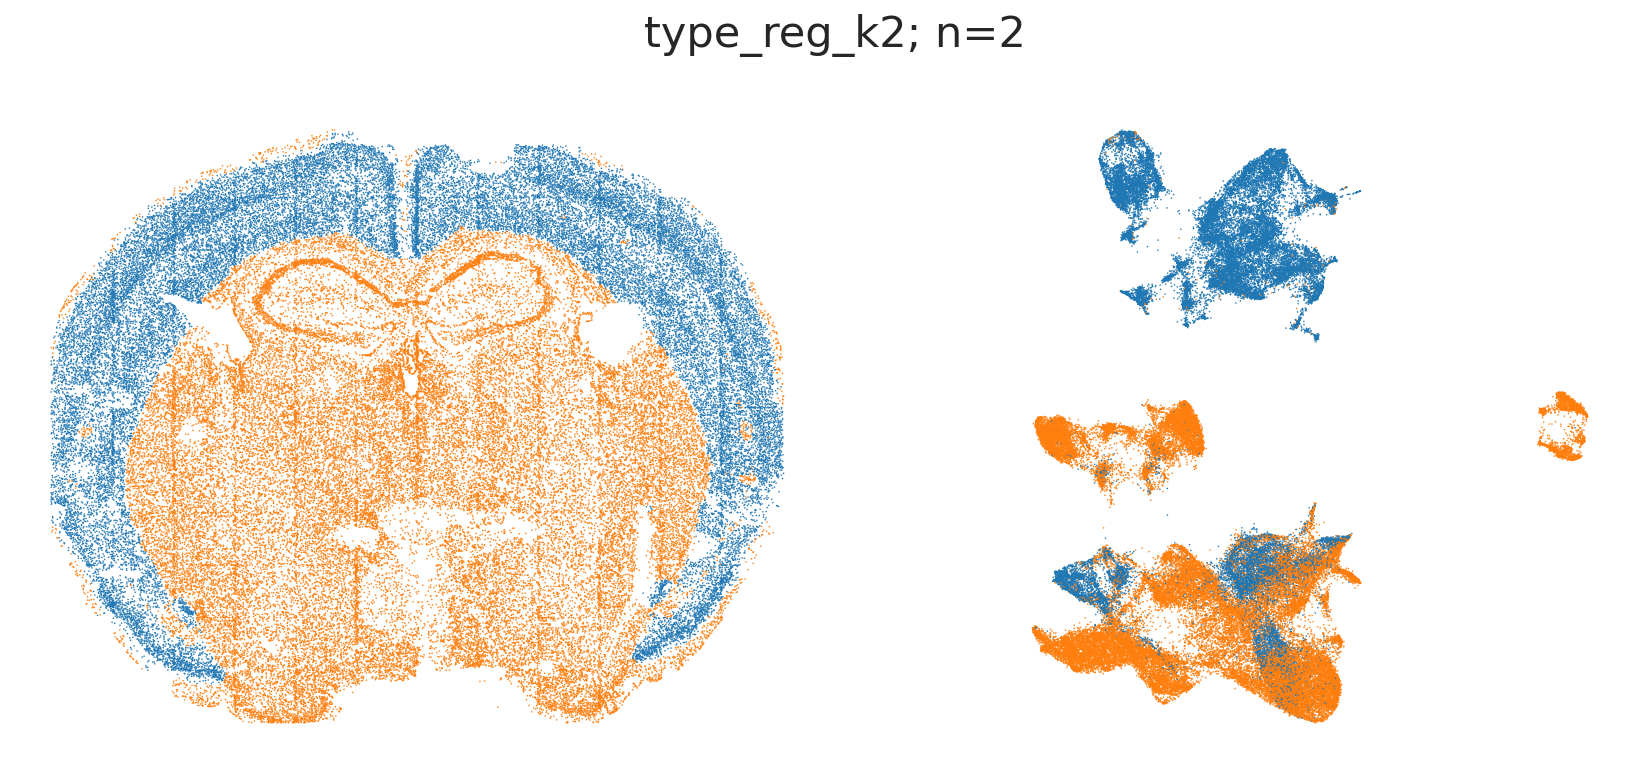

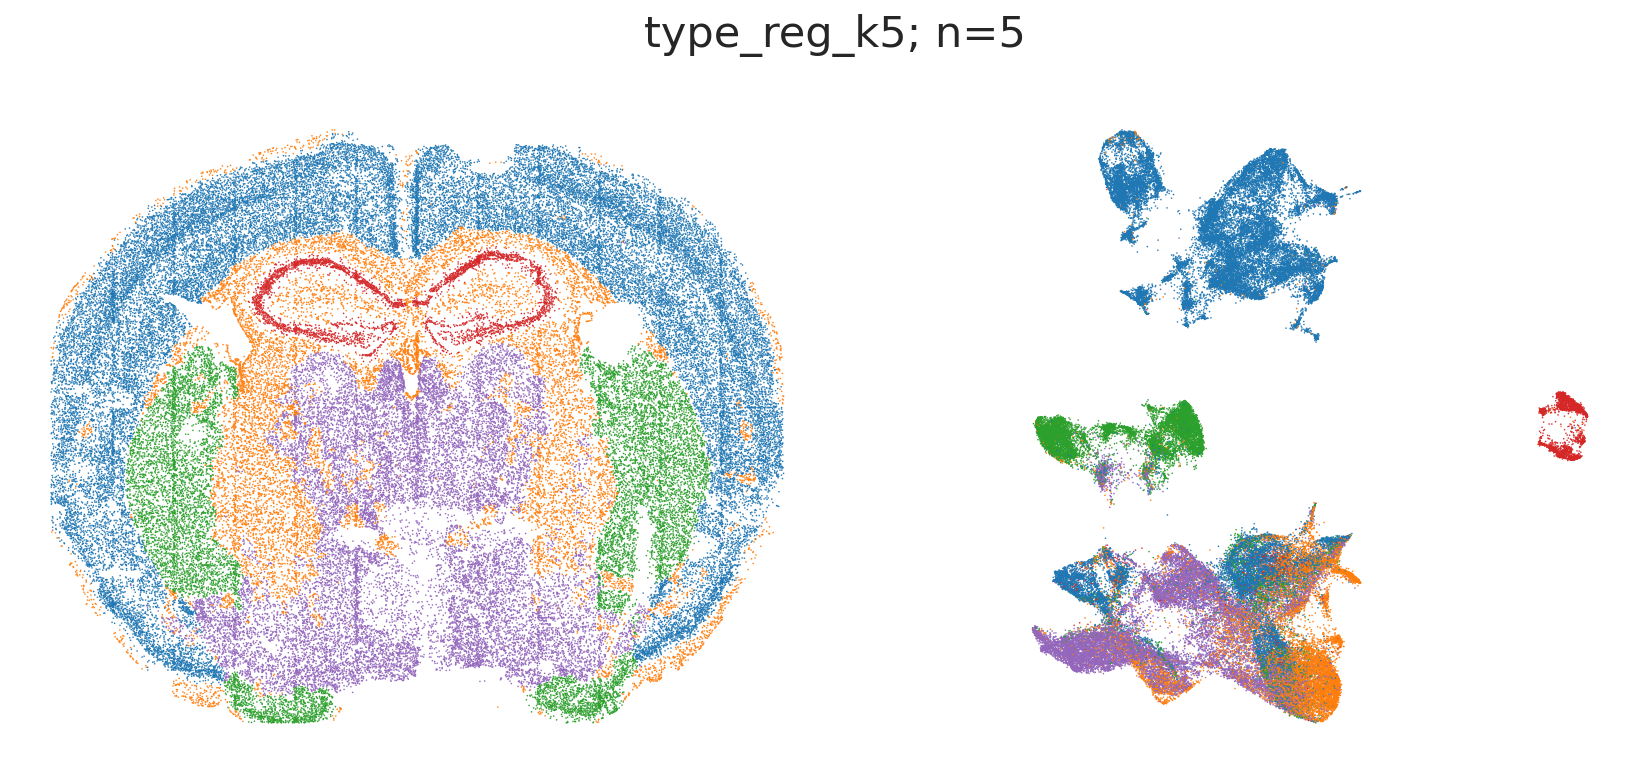

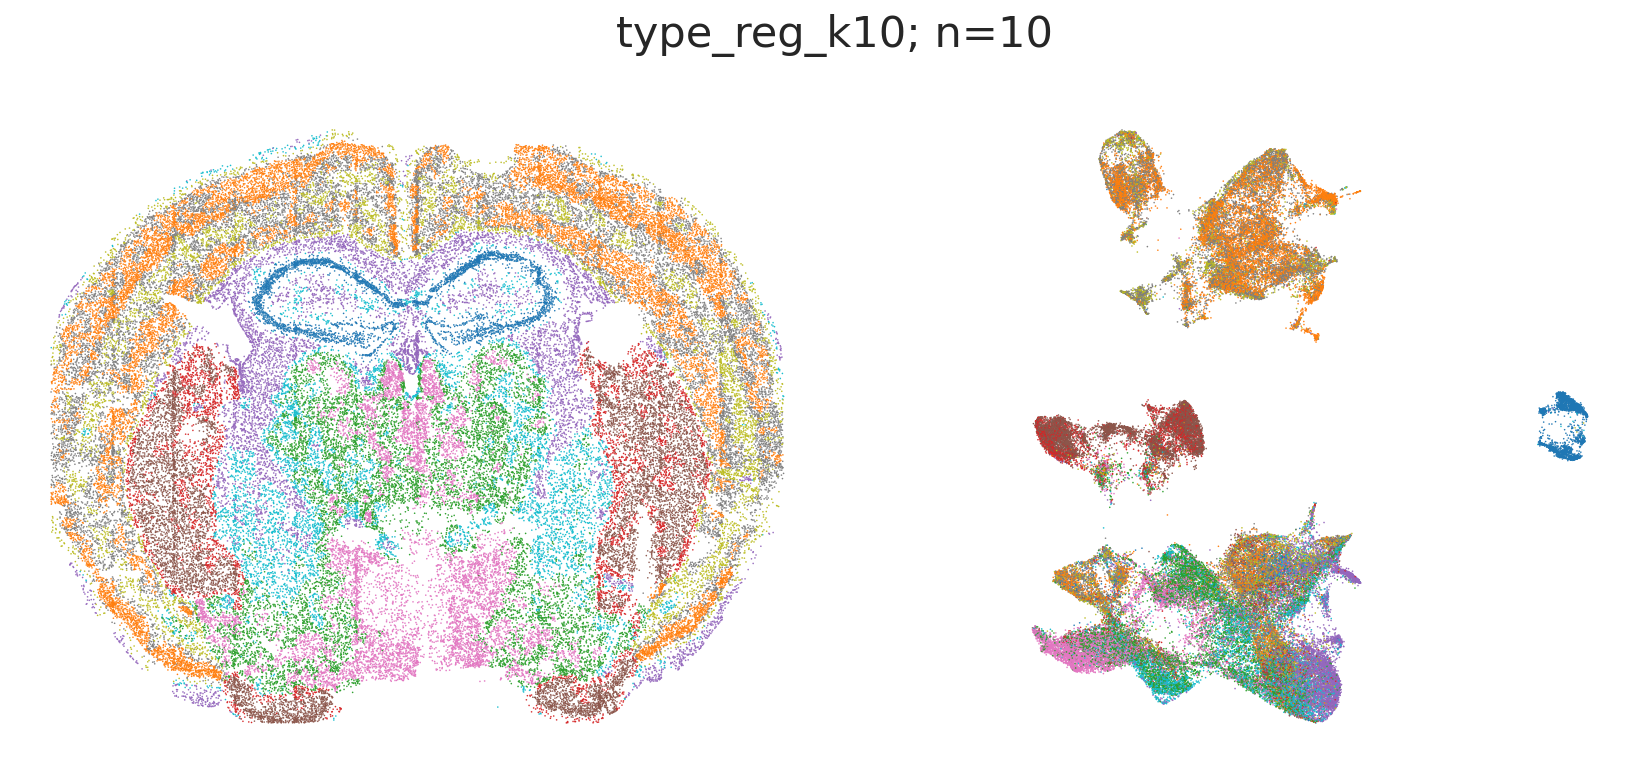

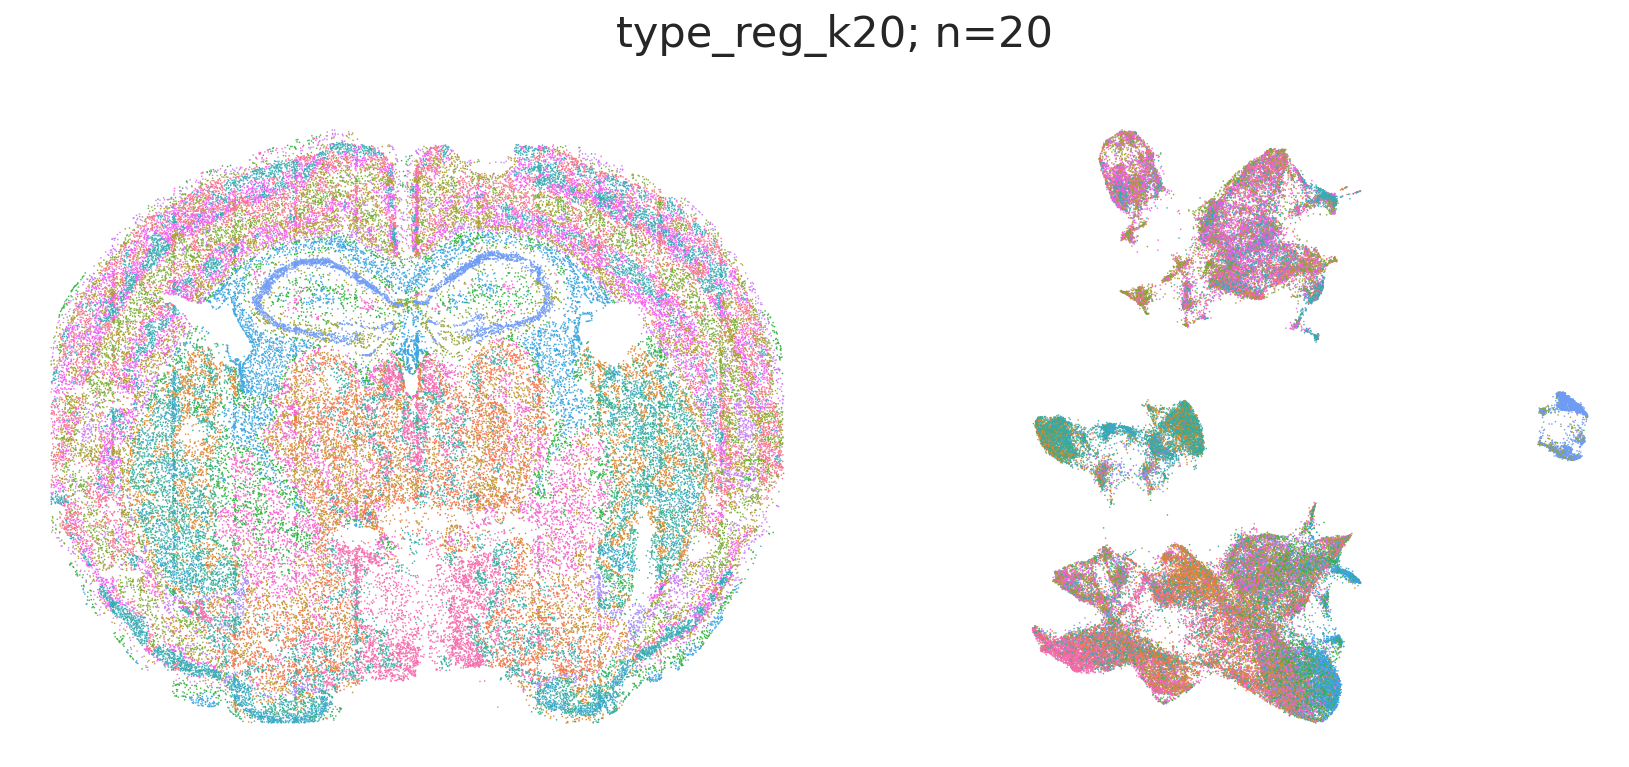

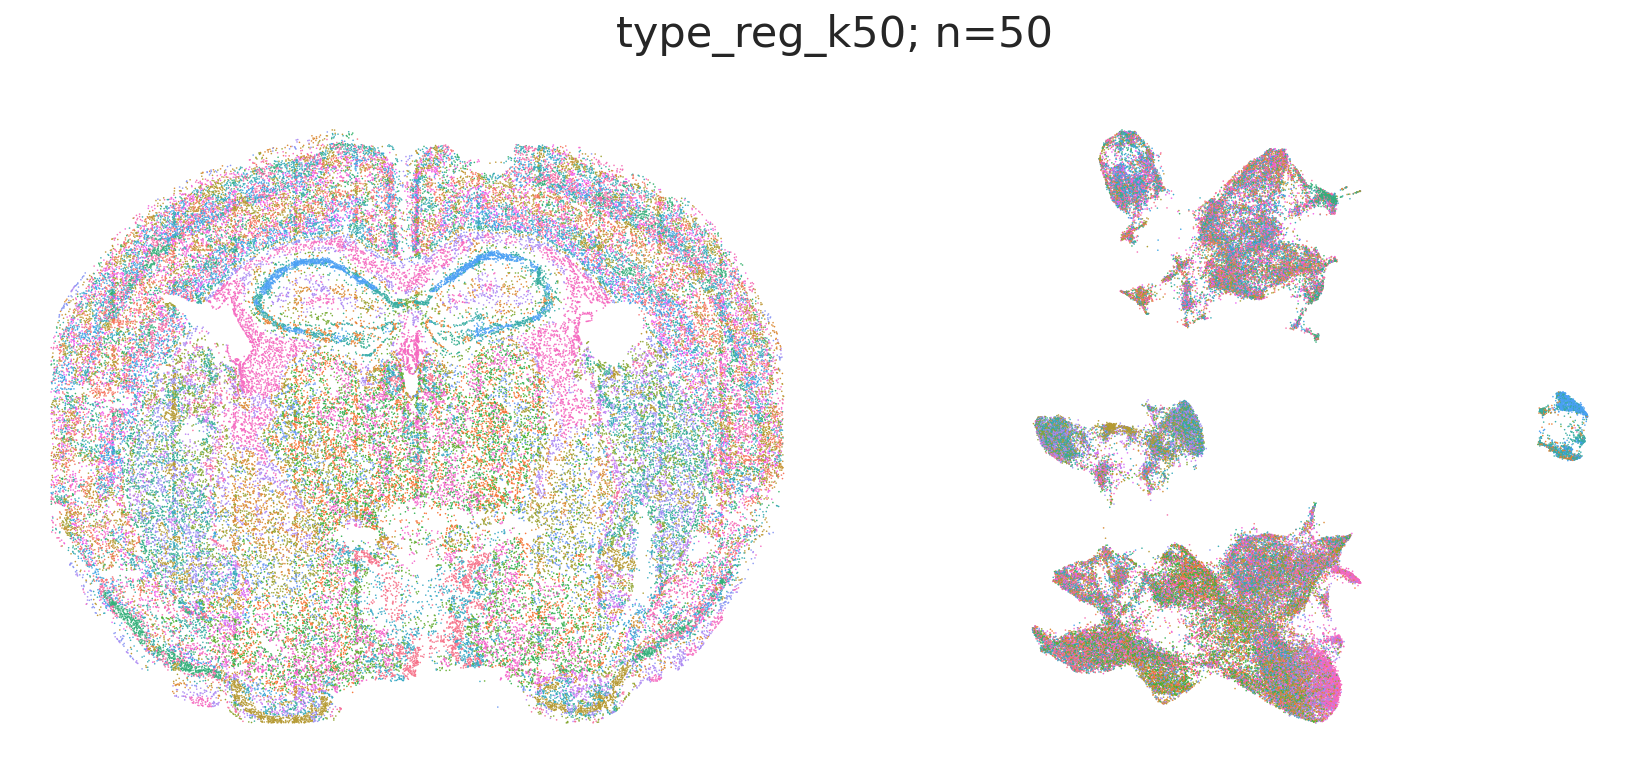

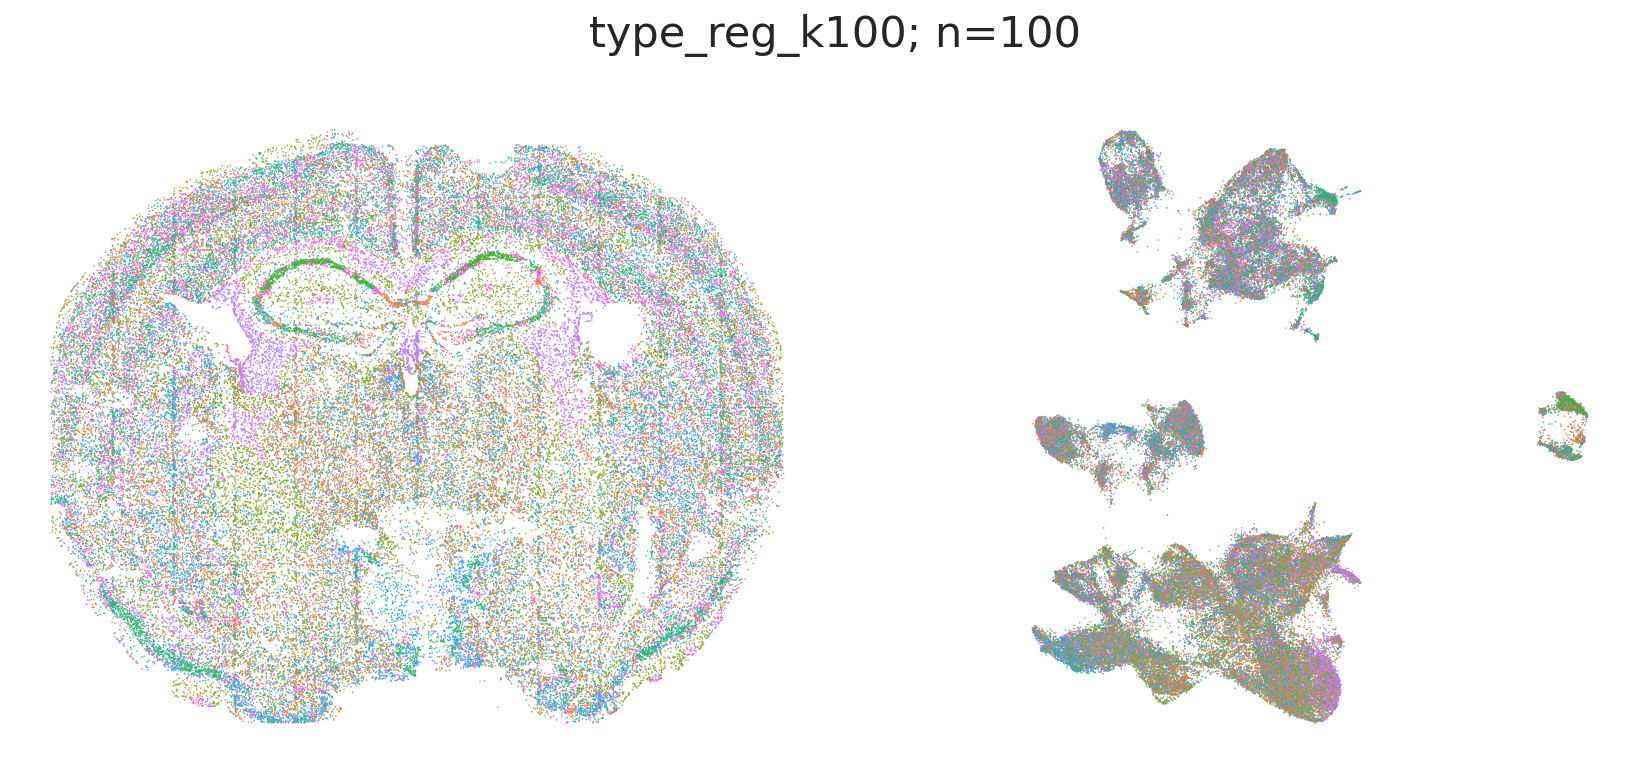

In [ ]:
for k_km in k_kms:
    hue = f'type_reg_k{k_km}'
    hue_order = np.sort(np.unique(df[hue]))
    ntypes = len(hue_order)

    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    fig.suptitle(f"{hue}; n={ntypes}")
    ax = axs[0]
    sns.scatterplot(data=df, x='x', y='y', 
                    hue=hue, hue_order=hue_order, 
                    s=0.5, edgecolor=None, 
                    legend=False,
                    ax=ax)
    # ax.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=5)
    ax.set_aspect('equal')
    ax.axis('off')

    ax = axs[1]
    sns.scatterplot(data=df, x='umap_x', y='umap_y', 
                    hue=hue, hue_order=hue_order, 
                    s=0.5, edgecolor=None, 
                    legend=False,
                    ax=ax)
    # ax.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=5)
    ax.set_aspect('equal')
    ax.axis('off')
    fig.subplots_adjust(wspace=0)
    plt.show()